Tomi Salomaa <br>
student number  <br>
  <br>
December, 4th, 2020  <br>

# Data Analysis and Knowledge Discovery: Exercise 3, Supervised learning

This is the template for the third exercise. The idea of this exercise is to apply supervised learning to predict the ship type using certain attributes (speed, destination harbour...) and K nearest neighbors (kNN) classifier. The data is available in Moodle course page: shipdata_2020.xlsx. <br> 

General guidance for exercises is given in Moodle course page. <br>

 - answer all the questions below
 - write easily readable code, include explanations what your code does
 - make informative illustrations: include labels for x- and y-axes, legends and captions for your plots
 - do not change anything manually or outside the script in the data file
 - before saving the ipynb file (and possible printing) run: "Restart & Run all", to make sure you return a file that works as expected
 - name your file as DAKD2020_ex3_firstname_lastname.ipynb
 - +1 bonus point requires a correct solution and also thorough analysis. Discuss also how the results could be improved
 - if you encounter problems, Google first. If you can't find an answer to the problem, don't hesitate to ask in the Moodle discussion or directly: pekavir@utu.fi
 - Note! Don't leave it to the last moment! No feedback service during the weekend
 - The deadline is **Friday 4th of December 23:59**

## Data import

Gather *all* packages needed for this notebook here:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as model_selection
from numpy import mean, absolute, sqrt
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from google.colab import files
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf

File ‘colab_pdf.py’ already there; not retrieving.



Import the data.

In [2]:
#uploaded = files.upload()
origData = pd.read_excel('shipdata_2020.xlsx')

## Data preprocessing

 - First, find out how many different destinations there are in the data. Do you need to make any preprocessing? **1p**
 - Destination harbor is a categorical variable. It needs to be converted into numerical. Explain, why do you need to make this step? You can use get_dummies from pandas to implement onehot coding for categorical features **1p**
 - Plot Gross tonnage versus the ship Length. Use different colors for different ship types. According to the plot, there is one clear outlier. Find the correct value from marinetraffic.com, and make the correction **1p**
 - It is good to exploit domain knowledge and make some reasonable transformation to the feature values to improve the expected results and/or to avoid redundancy. Find out what gross tonnage means. Make some transformation to Length values to acquire a linear relationship between the transformed length and Gross tonnage values **1p**
 - The numerical variables have quite different ranges. To ensure that all variables can have the same importance on the model, perform Z-score standardization. Perform it for speed, transformed length, and breadth **1p**

In [3]:
# Find out how many unique destinations in the data and whether preprocessing
# is needed or not.
shipdata2020 = origData
shipdata2020.info()
print('\n',shipdata2020['Destination'].value_counts(),'\n')
shipdata2020 = shipdata2020.replace('Sillamäe','Sillamae')
print('\n',shipdata2020['Destination'].value_counts(),'\n')
print('Unique destinations: ',shipdata2020['Destination'].value_counts().count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MMSI           134 non-null    int64  
 1   Speed          134 non-null    float64
 2   COG            134 non-null    float64
 3   Destination    134 non-null    object 
 4   Ship_type      134 non-null    object 
 5   Gross_tonnage  134 non-null    int64  
 6   Length         134 non-null    float64
 7   Breadth        134 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 8.5+ KB

 Hamina           19
Porvoo           18
Ust-Luga         16
Muuga            12
Tallinn          12
Paldiski          9
Valko-Loviisa     9
Kotka             8
Vuosaari          7
Viipuri           6
Primorsk          5
Vysotsk           5
Kronshtadt        2
Sillamäe          2
Kunda             2
Helsinki          1
Sillamae          1
Name: Destination, dtype: int64 


 Hamina          

<p><b>How many destinations are there? Any preprocessing needed?</b></p>
<p>Counting the unique destinations by applying the pandas value_counts() method to the 'Destinations' column and then applying count() gives us a result of 17 destinations. However, inspecting the value_counts() printed results shows two very similar destinations: Sillamäe and Sillamae. These are most likely the same destination of Sillamäe in Estonia, thus leading to the total count of <b>16 unique destinations</b>.</p>
<p>The observation made above already leads to the need of preprocessing. The two cases of <b>Sillamäe need to be corrected to Sillamae</b>. It would be logical that this is the correct form when it comes to international naming of the port and is further backed up by the marinetraffic.com port listing here https://www.marinetraffic.com/fi/ais/details/ports/2254</p>

In [4]:
# Perform One Hot encoding to destination values
destinationsEncoded = pd.get_dummies(shipdata2020['Destination'],prefix='Destination')
destinationsEncoded

,Destination_Hamina,Destination_Helsinki,Destination_Kotka,Destination_Kronshtadt,Destination_Kunda,Destination_Muuga,Destination_Paldiski,Destination_Porvoo,Destination_Primorsk,Destination_Sillamae,Destination_Tallinn,Destination_Ust-Luga,Destination_Valko-Loviisa,Destination_Viipuri,Destination_Vuosaari,Destination_Vysotsk
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
130,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


<p><b>Why is One Hot encoding needed?</b></p>
<p>The destinations aren't easily described as ordinal in nature and thus an integer representation is not enough to describe the destinations as a pure integer representation could provide poor results with predictions. This is because 1+2=3 but if we decided that Hamina = 1, Helsinki = 2 and Kotka = 3, we couldn't really say Hamina and Helsinki together are Kotka, even though numerically this would seem to be so (interpreting non-ordinal values as ordinal through integer encoding).</p>
<p>One Hot encoding solves this problem as the binary value also indicates which destinations are not true while also providing a numerical representation - required by many machine learning models - of the destination.</p>

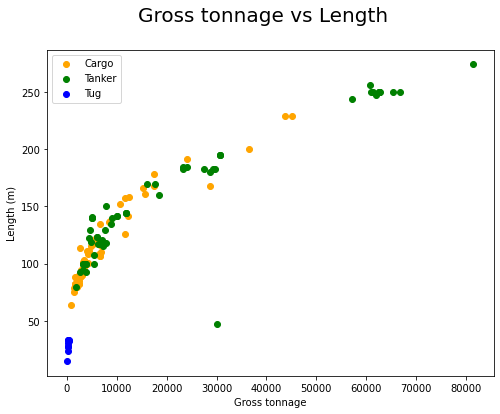

In [5]:
# Plotting gross tonnage vs length
fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle('Gross tonnage vs Length', fontsize=20)
ax.scatter(shipdata2020.loc[shipdata2020['Ship_type'] == 'Cargo'].Gross_tonnage,
        shipdata2020.loc[shipdata2020['Ship_type'] == 'Cargo'].Length,
        color='orange', label='Cargo')
ax.scatter(shipdata2020.loc[shipdata2020['Ship_type'] == 'Tanker'].Gross_tonnage,
        shipdata2020.loc[shipdata2020['Ship_type'] == 'Tanker'].Length,
        color='green', label='Tanker')
ax.scatter(shipdata2020.loc[shipdata2020['Ship_type'] == 'Tug'].Gross_tonnage,
        shipdata2020.loc[shipdata2020['Ship_type'] == 'Tug'].Length,
        color='blue', label='Tug')
ax.set_xlabel('Gross tonnage')
ax.set_ylabel('Length (m)')
plt.legend()

<p>Plotting a scatter plot of gross tonnage vs length displays a single 'Tanker' outlier with approximate values of length: 50m and gross tonnage: 30000.</p>

In [6]:
# Searching for the outlier
print(shipdata2020[shipdata2020['Gross_tonnage'].between(25000, 35000) &
                   shipdata2020['Length'].between(25, 75)])

         MMSI   Speed       COG  ... Gross_tonnage Length  Breadth
83  230212000  9.5779  125.0369  ...         30026  46.92     8.13

[1 rows x 8 columns]


<p>Searching for the outlier based on the scatter plot with parameters gross tonnage between 25000 and 35000 and length between 25 meters and 75 meters yields one result with MMSI of 230212000.</p>
<p>Searching the MMSI in MarineTraffic data gives a result of a Finnish tanker vessel TANKOS. Length seems to be correct but the reported gross tonnage is different (data: 30026, MarineTraffic 326).</p>
<p>https://www.marinetraffic.com/en/ais/details/ships/shipid:4814/mmsi:230212000/imo:5422203/vessel:TANKOS</p>

In [7]:
# Correcting the gross tonnage value of ship with MMSI 230212000
shipdata2020.loc[shipdata2020['MMSI'] == 230212000, ['Gross_tonnage']] = 326
print('Corrected row: \n',shipdata2020.iloc[83])
shipdata2020.shape

Corrected row: 
 MMSI             230212000
Speed               9.5779
COG                125.037
Destination        Tallinn
Ship_type           Tanker
Gross_tonnage          326
Length               46.92
Breadth               8.13
Name: 83, dtype: object


(134, 8)


Pearson´s before:
                    MMSI     Speed       COG  Gross_tonnage    Length   Breadth
MMSI           1.000000  0.131993 -0.020073       0.517002  0.512655  0.549096
Speed          0.131993  1.000000 -0.163144       0.205161  0.308384  0.298682
COG           -0.020073 -0.163144  1.000000      -0.015330 -0.128046 -0.056622
Gross_tonnage  0.517002  0.205161 -0.015330       1.000000  0.908635  0.953696
Length         0.512655  0.308384 -0.128046       0.908635  1.000000  0.963146
Breadth        0.549096  0.298682 -0.056622       0.953696  0.963146  1.000000

Pearson´s after:
                         MMSI     Speed  ...  Transformed_length   Breadth
MMSI                1.000000  0.131993  ...            0.531544  0.549096
Speed               0.131993  1.000000  ...            0.234282  0.298682
COG                -0.020073 -0.163144  ...           -0.033586 -0.056622
Gross_tonnage       0.517002  0.205161  ...            0.989989  0.953696
Transformed_length  0.531544  0.234282

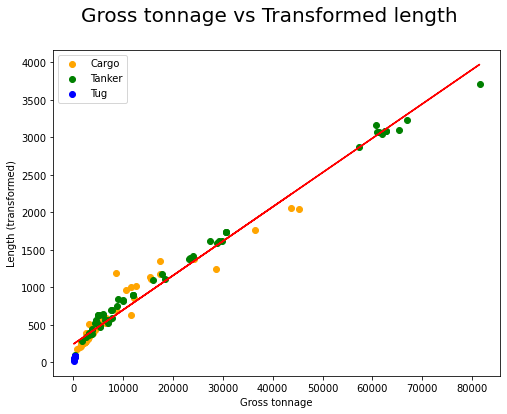

In [8]:
# Gross tonnage is calculated by multiplying the vessel's interior volume
# (Length x Width x Depth in cubic meters) by a variable k.
# The variable is determined by the vessel's overall volume in the manner of:
# k = 0.2 + 0.02*log10(volume)

print('\nPearson´s before:\n',shipdata2020.corr())
transformedShipData=shipdata2020
K = (0.2+0.02*np.log10(transformedShipData['Length']*transformedShipData['Breadth']))
transformedShipData['Length'] = K*transformedShipData['Length']*transformedShipData['Breadth']
transformedShipData = transformedShipData.rename(columns={'Length':
                                                          'Transformed_length'})

# Using polyfit to create linear line variables from the transformed data
m,b = np.polyfit(transformedShipData['Gross_tonnage'],
                 transformedShipData['Transformed_length'], 1)

# Plotting gross tonnage vs transformed length
fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle('Gross tonnage vs Transformed length', fontsize=20)
ax.scatter(transformedShipData.loc[transformedShipData['Ship_type'] == 'Cargo'].Gross_tonnage,
        transformedShipData.loc[transformedShipData['Ship_type'] == 'Cargo'].Transformed_length,
        color='orange', label='Cargo')
ax.scatter(transformedShipData.loc[transformedShipData['Ship_type'] == 'Tanker'].Gross_tonnage,
        transformedShipData.loc[transformedShipData['Ship_type'] == 'Tanker'].Transformed_length,
        color='green', label='Tanker')
ax.scatter(transformedShipData.loc[transformedShipData['Ship_type'] == 'Tug'].Gross_tonnage,
        transformedShipData.loc[transformedShipData['Ship_type'] == 'Tug'].Transformed_length,
        color='blue', label='Tug')
ax.set_xlabel('Gross tonnage')
ax.set_ylabel('Length (transformed)')

# To come up with the regression line below the helpful credit goes to
# https://www.kite.com/python/answers/how-to-plot-a-linear-regression-line-on-a-scatter-plot-in-python
plt.plot(transformedShipData['Gross_tonnage'], m*transformedShipData['Gross_tonnage'] + b,
         color='red')
plt.legend()
print('\nPearson´s after:\n',transformedShipData.corr())
print('\nDescribtion:\n',transformedShipData.describe())

<p>The gross tonnage is calculated by multiplying the volume of vessel's enclosed spaces by a variable K; GT=V*K. K is calculated with the following formula: 0.2+0.02*log10(V). (https://en.wikipedia.org/wiki/Gross_tonnage)</p>
<p>With this knowledge the logic in the above code was to try bringing the values of Length closer to the values of Gross Tonnage with the data we already have and in essence applying the K factor on top of this. This is not 100% linear as the dataset is missing parts to fully calculate the volume of any ship included in the dataframe.</p>
<p>Pearson's correlation and scatter plot were used to measure if any change would be noticable after the performed transformation. Pearson's correlation was quite high even before the transformation (0.9086) but grew even higher afterwards (0.99). The observed change seems feasible in the sense that most of the change happens in the early values of x / y axis whereas the orginal values themselves were quite "linear" after the early exponential growth. After appyling the transformation the exponential curve noticeably flattened.</p>

In [9]:
zScoreNumValues=transformedShipData
# Building a list from the numerical value columns of Speed, Transformed_length
# and Breadth
columnsZ=list(zScoreNumValues.columns)
columnsZ.remove('MMSI')
columnsZ.remove('COG')
columnsZ.remove('Destination')
columnsZ.remove('Ship_type')
columnsZ.remove('Gross_tonnage')

# Creating new zscore columns
for col in columnsZ:
    col_zscore=col+'_zscore'
    zScoreNumValues[col_zscore]=(zScoreNumValues[col]-zScoreNumValues[col]
                                 .mean())/zScoreNumValues[col].std(ddof=0)
zScoreNumValues

,MMSI,Speed,COG,Destination,Ship_type,Gross_tonnage,Transformed_length,Breadth,Speed_zscore,Transformed_length_zscore,Breadth_zscore
0,212209000,10.1377,64.3074,Hamina,Cargo,3416,383.289340,15.34,-0.161299,-0.551738,-0.489104
1,212436000,13.5256,77.0755,Hamina,Tanker,6280,560.688794,18.00,1.580209,-0.342632,-0.220696
2,219082000,9.9416,74.6762,Hamina,Tanker,9980,834.314387,21.90,-0.262102,-0.020102,0.172834
3,219083000,11.6038,74.7529,Hamina,Tanker,9980,822.520020,21.60,0.592331,-0.034004,0.142563
4,219426000,11.9203,56.3253,Hamina,Tanker,3219,394.874433,15.00,0.755024,-0.538083,-0.523412
...,...,...,...,...,...,...,...,...,...,...,...
129,273374820,10.0396,74.6253,Vysotsk,Tanker,4979,624.666149,16.70,-0.211726,-0.267220,-0.351873
130,273385070,9.3507,74.5454,Vysotsk,Tanker,4979,633.937111,16.94,-0.565847,-0.256292,-0.327656
131,273388150,9.7668,68.7159,Vysotsk,Tanker,5075,635.269724,16.86,-0.351956,-0.254722,-0.335728
132,636092755,11.1554,73.7013,Vysotsk,Tanker,23240,1372.359081,27.37,0.361837,0.614107,0.724786


## Classification accuracy with random training and test sets

Predict the **ship type** using **speed, destination, transformed length, and breadth** as features. Find an estimation for the classification accuracy (number of correctly classified ships to the total number of ships) using *random training and test sets*. <br>
 - Produce training and test data **1p**
     - Gather the normalized features and one-hot-coded destination columns as array __X__ (input variables), and the ship type as array **y** (output variable)     
     - Divide the data randomly into training (80%) and test (20%) sets
     (corrected to 80/20 as per email 1/12/2020 14:06)
     - Do you need to use stratification? Explain your decision
 - Train the model and test its performance **1p**
     - Use kNN classifier with k=3
     - Print out the confusion matrix. How does the model perform with different ship types?
     - What is the (total) classification accuracy?
 - Repeat the calculation 1000 times with different split of training/test data, and make a histogram of the results for classification accuracy **1p**
 - Discuss your results **1p**


Confusion:
 [[9 4 0]
 [3 9 0]
 [0 0 2]]

F1 score:  0.7407407407407407

Accuracy score:  0.7407407407407407


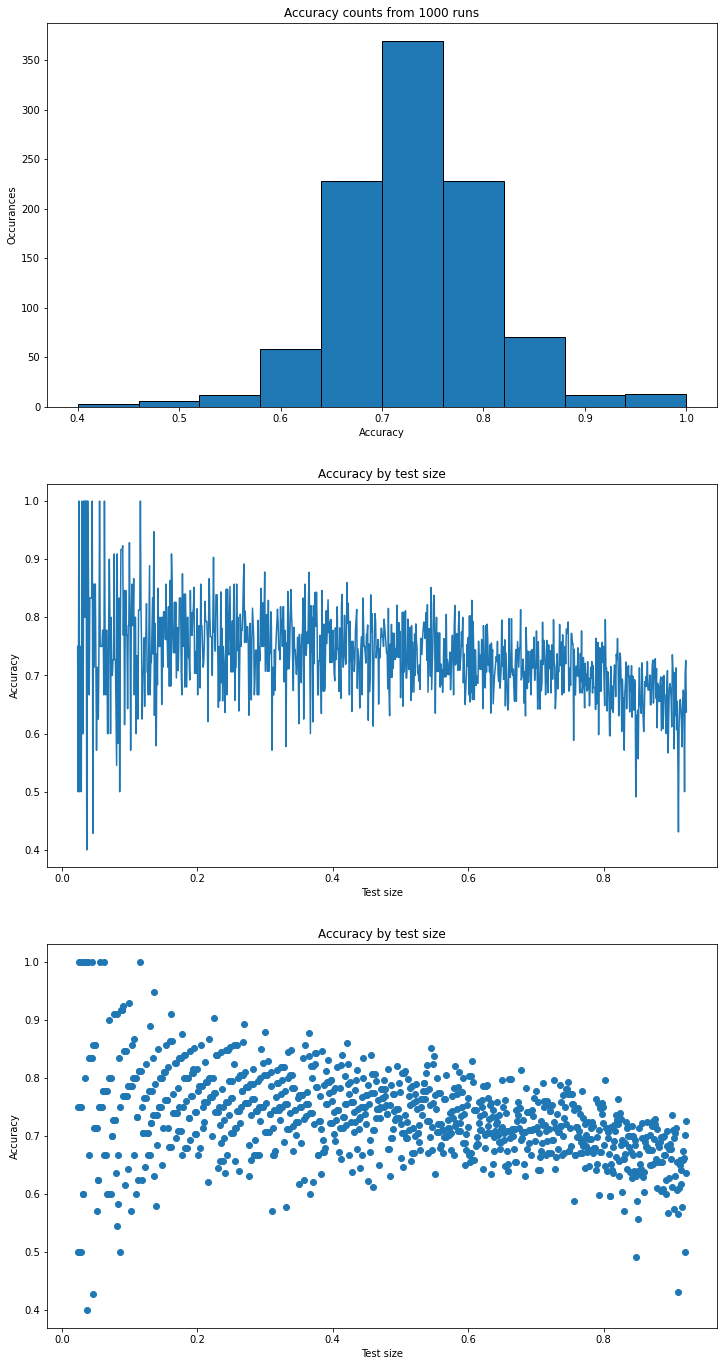

In [10]:
# Producing training and test data
tempFrame = zScoreNumValues[['Speed_zscore','Transformed_length_zscore','Breadth_zscore']]
x = pd.concat([tempFrame, destinationsEncoded],axis = 1)
y = transformedShipData['Ship_type']
xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.20, stratify=y, random_state=1)

# Building the model
classifier = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
classifier.fit(xTrain, yTrain)

# Evaluating the model with a single prediction
tempScore = []
f1Scores = []

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.20, stratify=y, random_state=1)
yPred = classifier.predict(xTest)
confusionMatrix = confusion_matrix(yTest, yPred)
print('\nConfusion:\n',confusionMatrix)
print('\nF1 score: ',f1_score(yTest, yPred, average='micro'))
print('\nAccuracy score: ',accuracy_score(yTest, yPred))

# Repeating 1000 times with different split each time
# The minimun samples required is 3 to allow for stratification
accuracyResults = []
testSizes = []
for k in range(1,1001):
  xTrain, xTest, yTrain, yTest = train_test_split(
      x, y, test_size=0.02239+0.0009*k, stratify=y)
  classifier.fit(xTrain, yTrain)
  yPred = classifier.predict(xTest)
  accuracyResults.append(accuracy_score(yTest, yPred))
  testSizes.append(0.02239+0.0009*k)

fig, axs = plt.subplots(3,1,figsize=(12,24))
axs[0].hist(accuracyResults, linewidth=1, edgecolor='black')
axs[0].set_title('Accuracy counts from 1000 runs')
axs[0].set_ylabel('Occurances')
axs[0].set_xlabel('Accuracy')
axs[1].plot(testSizes, accuracyResults)
axs[1].set_title('Accuracy by test size')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Test size')
axs[2].scatter(testSizes, accuracyResults)
axs[2].set_title('Accuracy by test size')
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Test size')
plt.show()

<p><b>Need for stratification?</b></p>
<p>Yes. As there are three labels that are not equally represented inside the data, they should be represented in proper label ratios inside the training sets. This most likely allows for better prediction and reproduceability of the results.</p>
<p><b>Discussing results</b></p>
<p>The prediction score floats around 70-80% through different runtime sessions. Effect of test size is noticeable. With a low test size there is understandably more variance between separate runtime runs and the prediction accuracy scores observed especially below test sizes of 0.1 should be handled with great critique. As the graphs show, with samples around n = ~13 the accuracy can reach near 100% but the true accuracy seems to constantly settle somewhere around 75-85% between the test sizes of 0.2-0.6. It is also worth mentioning that the performance decrease towards the test size of 1.0 is noticeable as well.</p>
<p>Random seeds for the training set splits were not used but the above observations seemed to be quite constant throughout several runtime sessions, as mentioned.</p>

## Classification accuracy using leave-one-out cross validation

Again, predict the **ship type** using **speed, destination, transformed length, and breadth** of the ship as features. Find an estimation for the classification accuracy using *leave-one-out cross validation (LOO CV)*. <br>

 - Use leave-one-out cross validation to estimate the model performance **1p**
     - Use kNN classifier with k=3
     - What is the classification accuracy? Compare the result with the one you got in the previous task
 - Which method gives better evaluation of the performance of the classifier with this data set? Explain your choice **1p**

In [11]:
loo = LeaveOneOut()
cValScores = []
aScores = []

for k in range(1,11):
  print('\nRound ',k,' of 10')
  xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.20, stratify=y)
  classifier = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
  classifier.fit(xTrain, yTrain)
  yPred = classifier.predict(xTest)
  cValScore = cross_val_score(classifier, xTrain, yTrain, cv=loo)
  aScore=accuracy_score(yTest, yPred)
  print('\nAccuracy score: ',aScore)
  print('\nF1 score: ',f1_score(yTest, yPred, average='micro'))
  confusionMatrix = confusion_matrix(yTest, yPred)
  print('\nConfusion:\n',confusionMatrix)
  cValScores.append(cValScore)
  aScores.append(aScore)

finalCvalAccuracyScore = mean(absolute(cValScores))
finalAccuracyScore = mean(aScores)
print('\nMean score of 10 cross validation scores: ',finalCvalAccuracyScore)
print('\nMean accuracy of 10 accuracy scores: ',finalAccuracyScore)


Round  1  of 10

Accuracy score:  0.7037037037037037

F1 score:  0.7037037037037037

Confusion:
 [[10  3  0]
 [ 3  9  0]
 [ 2  0  0]]

Round  2  of 10

Accuracy score:  0.7407407407407407

F1 score:  0.7407407407407407

Confusion:
 [[12  1  0]
 [ 4  8  0]
 [ 2  0  0]]

Round  3  of 10

Accuracy score:  0.7777777777777778

F1 score:  0.7777777777777778

Confusion:
 [[10  3  0]
 [ 1 11  0]
 [ 2  0  0]]

Round  4  of 10

Accuracy score:  0.7407407407407407

F1 score:  0.7407407407407407

Confusion:
 [[12  1  0]
 [ 3  8  1]
 [ 2  0  0]]

Round  5  of 10

Accuracy score:  0.6296296296296297

F1 score:  0.6296296296296297

Confusion:
 [[9 4 0]
 [5 7 0]
 [1 0 1]]

Round  6  of 10

Accuracy score:  0.7777777777777778

F1 score:  0.7777777777777778

Confusion:
 [[12  1  0]
 [ 3  9  0]
 [ 2  0  0]]

Round  7  of 10

Accuracy score:  0.7037037037037037

F1 score:  0.7037037037037037

Confusion:
 [[10  3  0]
 [ 3  9  0]
 [ 2  0  0]]

Round  8  of 10

Accuracy score:  0.8888888888888888

F1 score:

<p><b>Which method gives better evaluation?</b></p>
<p>The evaluation results regarding the accuracy score seems equal to the method observed earlier.</p>
<p>While the score here was calculated using the mean of 10 rounds, this most likely wouldn't have been necessary as the LOOCV itself runs many sample sets with one session and should in general be better for lightweight datasets.</p>
<p>Though the score occasionally jumped over the 0.8 levels, average settled to be equal to the method used before even observed through multiple runtime sessions and no random seed.</p>
<p>It is also worth to note that all the methods used here were put into action without much tweaking or attempt to optimize the parameters. While I have no expertise to say if something more should have been included or changed one way or another, there probably would have been more room for optimization.</p>

## Model selection with leave-one-out cross validation

- Select the best model (kNN with selection of k) using leave-one-out cross validation **2p**
    - Repeat the model performance estimation with values k=1...30
    - Which value of k produces the best classification accuracy?
    - If the number of k is still increased, what is the limit that the classification accuracy approaches? Why?
- Can you say something about the performance of this *selected* model with new, unseen data? Explain, how you could you estimate the performance of this selected model. **1p**


Score with k value  1  =  0.7102803738317757

Score with k value  2  =  0.7476635514018691

Score with k value  3  =  0.7663551401869159

Score with k value  4  =  0.7476635514018691

Score with k value  5  =  0.7663551401869159

Score with k value  6  =  0.7383177570093458

Score with k value  7  =  0.7383177570093458

Score with k value  8  =  0.6822429906542056

Score with k value  9  =  0.7757009345794392

Score with k value  10  =  0.7383177570093458

Score with k value  11  =  0.7102803738317757

Score with k value  12  =  0.7757009345794392

Score with k value  13  =  0.7476635514018691

Score with k value  14  =  0.7102803738317757

Score with k value  15  =  0.6728971962616822

Score with k value  16  =  0.7009345794392523

Score with k value  17  =  0.7570093457943925

Score with k value  18  =  0.7476635514018691

Score with k value  19  =  0.7289719626168224

Score with k value  20  =  0.6822429906542056

Score with k value  21  =  0.6635514018691588

Score with k value  2

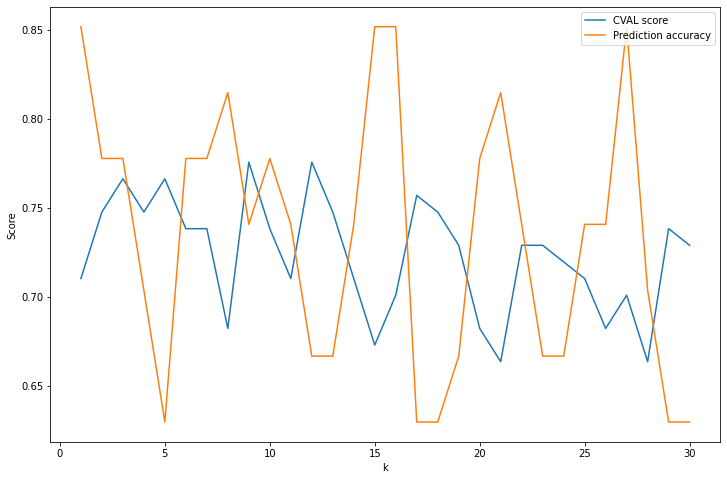

In [12]:
cValResults = []
accuracyResults = []
fResults = []
testKvalue = []

for k in range(1,31):
  xTrain, xTest, yTrain, yTest = train_test_split(
      x, y, test_size=0.20, stratify=y)
  classifier = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  classifier.fit(xTrain, yTrain)
  xScores = []
  xScores = cross_val_score(classifier, xTrain, yTrain, cv=loo)
  print('\nScore with k value ',k,' = ',mean(absolute(xScores)))
  cValResults.append(mean(absolute(xScores)))
  testKvalue.append(k)
  yPred = classifier.predict(xTest)
  aScore=accuracy_score(yTest, yPred)
  fScore=f1_score(yTest, yPred, average='micro')
  accuracyResults.append(aScore)
  fResults.append(fScore)

fig,axs = plt.subplots(figsize=(12,8))
plt.xlabel("k")
plt.ylabel("Score")
axs.plot(testKvalue, cValResults, label='CVAL score')
axs.plot(testKvalue, accuracyResults, label='Prediction accuracy')
axs.legend()
plt.show()

<p>Judging from the graph, the optimal amount of neighbors for kNN seems to be around k=2 and k=5, the k=5 showing up most constantly.</p>
<p>The accuracy of the model seems to get gradually worse after some k=45. After running the evaluation up to k=100 the accuracy seemed to settle around 50% which would make sense as the cargo and tanker type labels are closely and quite evenly packed in our dataset as visualized by the graphs in the beginning of the exercise. The tug boats will most likely fall through predictions all together in the early k-numbers due to their limited presence inside the dataset, causing them to "lose the votes".</p>
<p>With new unseen data this model would most likely perform equally well as demonstrated here in the evaluations, assuming the ratio of ship types stays approximately the same.</p>

## Testing with training data (this should not be used!)

- Repeat the previous task but use the whole data for training **2p**
    - Plot the resulting classification accuracy versus k=1...30. Include the values from the previous task in the same figure
    - Comment your result. Why shouldn't you test with training data?


Score with k value  1  =  0.7388059701492538

Accuracy score:  1.0

F1 score:  1.0

Confusion:
 [[67  0  0]
 [ 0 58  0]
 [ 0  0  9]]

Score with k value  2  =  0.7686567164179104

Accuracy score:  0.8656716417910447

F1 score:  0.8656716417910447

Confusion:
 [[67  0  0]
 [13 45  0]
 [ 4  1  4]]

Score with k value  3  =  0.7686567164179104

Accuracy score:  0.8880597014925373

F1 score:  0.8880597014925373

Confusion:
 [[62  5  0]
 [ 6 51  1]
 [ 3  0  6]]

Score with k value  4  =  0.7686567164179104

Accuracy score:  0.8582089552238806

F1 score:  0.8582089552238806

Confusion:
 [[65  2  0]
 [10 47  1]
 [ 6  0  3]]

Score with k value  5  =  0.7835820895522388

Accuracy score:  0.8507462686567164

F1 score:  0.8507462686567164

Confusion:
 [[59  8  0]
 [ 8 50  0]
 [ 4  0  5]]

Score with k value  6  =  0.7761194029850746

Accuracy score:  0.835820895522388

F1 score:  0.835820895522388

Confusion:
 [[62  5  0]
 [11 47  0]
 [ 6  0  3]]

Score with k value  7  =  0.7761194029850746

A

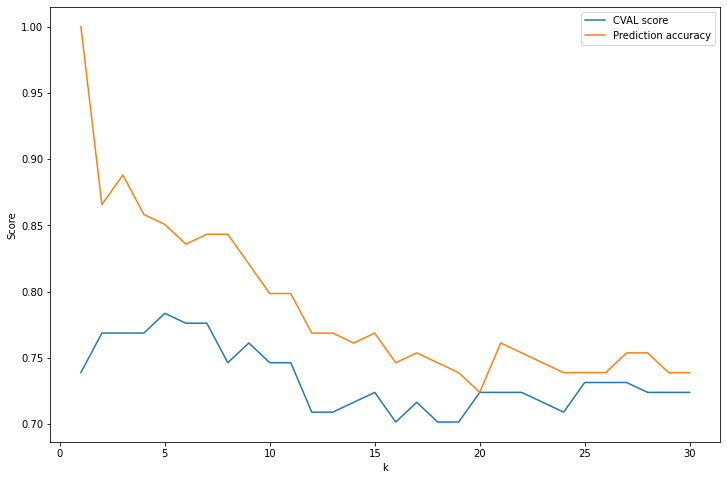

In [13]:
cValResults = []
accuracyResults = []
fResults = []
testKvalue = []

for k in range(1,31):
  classifier = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  classifier.fit(x, y)
  xScores = []
  xScores = cross_val_score(classifier, x, y, cv=loo)
  print('\nScore with k value ',k,' = ',mean(absolute(xScores)))
  cValResults.append(mean(absolute(xScores)))
  testKvalue.append(k)
  yPred = classifier.predict(x)
  aScore=accuracy_score(y, yPred)
  fScore=f1_score(y, yPred, average='micro')
  accuracyResults.append(aScore)
  fResults.append(fScore)
  print('\nAccuracy score: ',aScore)
  print('\nF1 score: ',fScore)
  confusionMatrix = confusion_matrix(y, yPred)
  print('\nConfusion:\n',confusionMatrix)

fig,axs = plt.subplots(figsize=(12,8))
plt.xlabel("k")
plt.ylabel("Score")
axs.plot(testKvalue, cValResults, label='CVAL score')
axs.plot(testKvalue, accuracyResults, label='Prediction accuracy')
axs.legend()
plt.show()

<p>A quick glance at cross validation scores during the run would imply that not much changes with the scores in comparison the graph together with the predict accuracy tells differently. There is much less variance overall in CVAL score and the prediction starts from 100% but the degrading is gradual.</p>
<p>The problems testing with the training data (and training with all the data) is that the model learns the details and noise in the data and thus isn't as generalizable to a new unseen dataset when it comes to predicting.</p>

In [14]:
colab_pdf('DAKD2020_ex3_tomi_salomaa.ipynb')

Mounted at /content/drive/
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://security.ubuntu.com/ubuntu bi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'